## Imports

In [4]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Helper Function

In [5]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def load_from_pickle(file_path):
    """
    Load and return the Python object from a pickle file.
    
    Parameters:
    - file_path: str, the path to the pickle file to be loaded.
    
    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    # Modify this function based on your grid conversion logic
    return pos[0], pos[1]  # Example conversion

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## Code to implement spatial activity profile method

### Helper functions

In [6]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

### Look at 30 events BEFORE

In [7]:
# Looking at 30 events BEFORE

def create_distance_angle_histograms_before(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        start_rank = max(0, current_event_id - rank_window)
        end_rank = current_event_id

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            # print("Distance: ", distance)
            angle = angles[current_neuron_id, other_neuron_id]
            # print("Angle: ", angle)

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Look at 30 events AFTER

In [8]:
# Looking at 30 events AFTER

def create_distance_angle_histograms_after(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        # Adjust the rank window to look at events after the current event
        start_rank = current_event_id + 1  # Start from the next event
        end_rank = min(total_events, current_event_id + rank_window + 1)  # Ensure not to exceed the total events

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Other processing

In [9]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram sum is zero
    if np.sum(angle_hist) == 0:
        # Handle the case where the histogram sum is zero
        # For example, return None or raise an error
        return np.nan  # or consider raising an error or returning a default value

    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, spatial_range=(0, 10), bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(spatial_range[0], spatial_range[1], bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

## PLOTTER

In [10]:
def plot_data(data, title):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    # Invert y axis
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()

## Data

In [11]:
from human_hip import spike_data

hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip')
hc_112823 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip')
hc_112823_2 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base2_acqm.zip')
hc_120523_chip21769 = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

hc_328 = transform_neuron_data(hc_328)
hc_52 = transform_neuron_data(hc_52)
hc_111 = transform_neuron_data(hc_111)
hc_112823 = transform_neuron_data(hc_112823)
hc_112823_2 = transform_neuron_data(hc_112823_2)
hc_120523_chip21769 = transform_neuron_data(hc_120523_chip21769)

/tmp/ipykernel_54492/3302845650.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')


In [9]:
def analyze_spike_data(spikedata, spatial_range=(0, 50), rank_window=500, bins=6):
    """
    Analyzes spike data to compute histograms and averages before and after certain events.

    Parameters:
    - spikedata: The spike data to analyze.
    - spatial_range: A tuple defining the spatial range to consider.
    - rank_window: The rank window size for event calculation. Default is 500.
    - bins: The number of bins for histograms. Default is 6.

    Returns:
    A dictionary containing the before and after averages for distances, angles, and events per neuron.
    """
    # Calculate event ranks
    event_ranks = calculate_event_ranks(spikedata)
    
    # Create histograms
    before_histograms = create_distance_angle_histograms_before(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    after_histograms = create_distance_angle_histograms_after(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    
    # Compute averages
    before_average_distances_angles = compute_average_distance_angle(before_histograms, spatial_range=spatial_range, bins=bins)
    after_average_distances_angles = compute_average_distance_angle(after_histograms, spatial_range=spatial_range, bins=bins)
    
    # Average events per neuron
    before_average_events_per_neuron = average_events_per_neuron(spikedata, before_average_distances_angles)
    after_average_events_per_neuron = average_events_per_neuron(spikedata, after_average_distances_angles)
    
    return before_average_events_per_neuron, after_average_events_per_neuron

In [122]:
hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, 200), rank_window=20, bins=6)
hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 200), rank_window=20, bins=6)
hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, 200), rank_window=20, bins=6)
hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, 200), rank_window=20, bins=6)
hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, 200), rank_window=20, bins=6)
hc_120523_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, 200), rank_window=20, bins=6)

Total unique events: 49667
Processing event 0 of 49667


/tmp/ipykernel_919/2876065909.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 4966 of 49667
Processing event 9932 of 49667
Processing event 14898 of 49667
Processing event 19864 of 49667
Processing event 24830 of 49667
Processing event 29796 of 49667
Processing event 34762 of 49667
Processing event 39728 of 49667
Processing event 44694 of 49667
Processing event 49660 of 49667
Processing complete
Processing event 0 of 49667
Processing event 4966 of 49667
Processing event 9932 of 49667
Processing event 14898 of 49667
Processing event 19864 of 49667
Processing event 24830 of 49667
Processing event 29796 of 49667
Processing event 34762 of 49667
Processing event 39728 of 49667
Processing event 44694 of 49667
Processing event 49660 of 49667
Processing complete
Total unique events: 49667
Total unique events: 49667
Total unique events: 21747
Processing event 0 of 21747
Processing event 2174 of 21747
Processing event 4348 of 21747
Processing event 6522 of 21747
Processing event 8696 of 21747
Processing event 10870 of 21747
Processing event 13044 of 21747

In [239]:
def plot_data_comparison(data_before, data_after):
    """
    Plots two datasets on a single figure with two subplots placed one above the other.
    The top subplot shows 'data_before' with lightblue points and the bottom subplot
    shows 'data_after' with red points. Arrows indicate direction and distance, skipping
    points with 'nan' angles.

    Parameters:
    - data_before: A dictionary for the dataset before activity, where each key is an identifier and
                   each value is a dictionary containing 'distance', 'angle', and 'position'.
    - data_after: A dictionary for the dataset after activity, similar in structure to data_before.
    """
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Creating two subplots

    for ax, data, title, color in zip(axs, [data_before, data_after], ["Before Activity", "After Activity"], ['lightblue', 'red']):
        for key, value in data.items():
            position = np.array(value['position'])
            angle = value['angle']
            distance = value['distance']

            # Plotting the point
            ax.plot(position[0], position[1], 'o', color=color)

            # Skip plotting the arrow if angle is nan
            if not np.isnan(angle):
                # Calculate the end point of the arrow
                end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])

                # Plotting the arrow with specified appearance
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

        ax.set_aspect('equal')
        # ax.invert_yaxis()
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

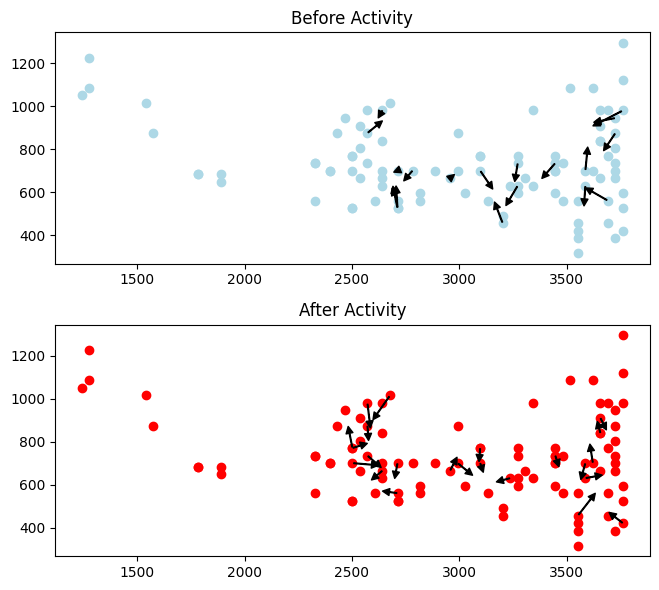

In [240]:
plot_data_comparison(hc_52_data[0], hc_52_data[1])

In [227]:
# # def plot_all_data(datasets, titles):
# #     """
# #     Plots all datasets in a figure with 6 subplots (3 rows, 2 columns), ensuring equal size for all subplot boxes
# #     and minimal space between them. Aims for an overall figure size of 8x8.

# #     Parameters:
# #     - datasets: A list of dictionaries, where each dictionary represents a dataset.
# #     - titles: A list of titles for each subplot.
# #     """
# #     nrows = 3  # Number of rows
# #     ncols = 2  # Number of columns
# #     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8),
# #                             gridspec_kw={'wspace': 0.1, 'hspace': 0.2})  # Adjust spacing here

# #     for idx, (data, title) in enumerate(zip(datasets, titles)):
# #         ax = axs[idx // ncols, idx % ncols]

# #         for key, value in data.items():
# #             position = np.array(value['position'])
# #             angle = value['angle']
# #             distance = value['distance']
# #             color = 'lightblue' if idx % 2 == 0 else 'red'

# #             if idx == 0 or idx == 1:  # Zero-based index for rows, so the third row is index 2
# #                 position = position[::-1]  # Swap x and y
# #                 angle += np.pi / 2

# #             ax.plot(position[0], position[1], 'o', color=color, markersize=4)

# #             if not np.isnan(angle):
# #                 end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
# #                 ax.annotate('', xy=end_point, xytext=position,
# #                             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

# #         ax.set_aspect('equal')
# #         ax.invert_yaxis()
# #         ax.set_title(title)

# #     # Adjusting legend to be more compact or outside the plotting area if needed
# #     fig.legend([Patch(color='lightblue', label='Before'), 
# #                 Patch(color='red', label='After'), 
# #                 FancyArrow(0, 0, 0.1, 0.1, color='black')],
# #                ['Before', 'After', 'Direction'], 
# #                loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# #     plt.tight_layout(w_pad=5)  # Adjust padding between and around subplots
# #     plt.show()


# # # def plot_all_data(datasets, titles):
# # #     """
# # #     Plots all datasets in a figure with 6 subplots (3 rows, 2 columns), adjusting the layout as specified.
# # #     Attempts to maintain an aspect ratio close to 3:2 for the entire figure.

# # #     Parameters:
# # #     - datasets: A list of dictionaries, where each dictionary represents a dataset.
# # #     - titles: A list of titles for each subplot.
# # #     """
# # #     nrows = 3  # Number of rows
# # #     ncols = 2  # Number of columns
# # #     fig_width = 12  # Total figure width
# # #     fig_height = 9  # Total figure height to maintain a 3:2 ratio across the figure
# # #     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))

# # #     # Ensure axs is a 2D array for consistency in indexing
# # #     if nrows * ncols == 1:
# # #         axs = np.array([[axs]])
# # #     elif nrows == 1 or ncols == 1:
# # #         axs = axs.reshape(nrows, ncols)

# # #     for idx, (data, title) in enumerate(zip(datasets, titles)):
# # #         ax = axs[idx // ncols, idx % ncols]

# # #         for key, value in data.items():
# # #             position = np.array(value['position'])
# # #             angle = value['angle']
# # #             distance = value['distance']
# # #             color = 'lightblue' if idx % 2 == 0 else 'red'

# # #             # For the third row, swap the x and y positions and adjust the angle accordingly
# # #             if idx == 0 or idx == 1:  # Zero-based index for rows, so the third row is index 2
# # #                 position = position[::-1]  # Swap x and y
# # #                 angle += np.pi / 2  # Rotate the angle by 90 degrees

# # #             # Logical rotation is not required here as per the updated instruction,
# # #             # but you can reintroduce the condition if necessary for specific rows

# # #             # Plot adjustment for visibility
# # #             ax.plot(position[0], position[1], 'o', color=color, markersize=4)

# # #             if not np.isnan(angle):
# # #                 end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
# # #                 ax.annotate('', xy=end_point, xytext=position,
# # #                             arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

# # #         ax.set_aspect('equal')
# # #         ax.invert_yaxis()
# # #         ax.set_title(title)
    
# # #     fig.legend([Patch(color='lightblue', label='Before'), 
# # #                 Patch(color='red', label='After'), 
# # #                 FancyArrow(0, 0, 0.1, 0.1, color='black')],
# # #                ['Before', 'After', 'Direction'], 
# # #                loc='upper right')

# # #     plt.tight_layout()
# # #     plt.show()

# def combined_arrow_plots(data_info):
#     """
#     Creates a figure with arrow plots across 3 rows and 2 columns, incorporating specified adjustments.

#     Args:
#         data_info (list): A list of tuples containing data and configuration for each plot.
#                           Each tuple should have the format:
#                           (data, title, is_rotated)
#     """
#     nrows, ncols = 3, 2
#     fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

#     for idx, (data, title, is_rotated) in enumerate(data_info):
#         ax = axs[idx // ncols, idx % ncols]

#         # Prepare positions and optionally rotate
#         positions = np.array([value['position'] for value in data.values()])
#         if is_rotated:
#             positions = positions[:, ::-1]  # Swap x and y for rotation
#             angles = [value['angle'] + np.pi/2 for value in data.values()]
#         else:
#             angles = [value['angle'] for value in data.values()]

#         # Plot neurons
#         ax.scatter(positions[:, 0], positions[:, 1], color='red', s=12)

#         # Plot arrows
#         for pos, angle, value in zip(positions, angles, data.values()):
#             if np.isnan(angle): continue
#             distance = value['distance']
#             end_pos = pos + np.array([np.cos(angle) * distance, np.sin(angle) * distance])
#             ax.annotate('', xy=end_pos, xytext=pos,
#                         arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

#         # Adjustments for rotated plots
#         if is_rotated:
#             ax.set_xlabel('Y position')
#             ax.set_ylabel('X position')
#             ax.invert_xaxis()  # Optional: Invert x-axis if rotation logic requires it
#         else:
#             ax.set_xlabel('X position')
#             ax.set_ylabel('Y position')
#             ax.invert_yaxis()  # Usually for images but here to maintain consistency with your data's orientation

#         ax.set_title(title)
#         ax.axis('equal')

#     # Adjust layout and add global legends for the figure
#     plt.tight_layout(pad=0.5)

#     node_type_legend_elements = [
#         Patch(color='red', label='Neuron', markersize=10)
#     ]

#     axs[0, 0].legend(handles=node_type_legend_elements, loc='upper right')

#     plt.show()

In [249]:
def combined_arrow_plots(data_info):
    """
    Creates a figure with arrow plots across 3 rows and 2 columns, where neurons in the left column are blue and
    those in the right column are red, incorporating specified adjustments.

    Args:
        data_info (list): A list of tuples containing data and configuration for each plot.
                          Each tuple should have the format:
                          (data, title, is_rotated)
    """
    nrows, ncols = 3, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

    for idx, (data, title, is_rotated, x_window, y_window) in enumerate(data_info):
        ax = axs[idx // ncols, idx % ncols]

        # Determine neuron color based on column
        neuron_color = 'lightblue' if idx % ncols == 0 else 'red'

        # Prepare positions and optionally rotate
        positions = np.array([value['position'] for value in data.values()])
        if is_rotated:
            positions = positions[:, ::-1]  # Swap x and y for rotation
            angles = [value['angle'] + np.pi/2 for value in data.values()]
        else:
            angles = [value['angle'] for value in data.values()]

        # Plot neurons with the determined color
        ax.scatter(positions[:, 0], positions[:, 1], color=neuron_color, s=12)

        # Plot arrows
        for pos, angle, value in zip(positions, angles, data.values()):
            if np.isnan(angle): continue
            distance = value['distance']
            end_pos = pos - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            ax.annotate('', xy=end_pos, xytext=pos,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

        # Adjustments for rotated plots
        if is_rotated:
            ax.set_xlabel('Y position')
            ax.set_ylabel('X position')
            # ax.invert_xaxis()  # Optional: Invert x-axis if rotation logic requires it
        else:
            ax.set_xlabel('X position')
            ax.set_ylabel('Y position')
            # ax.invert_yaxis()  # Usually for images but here to maintain consistency with your data's orientation

        ax.set_title(title)
        ax.axis('equal')

        ax.set_xlim(x_window)
        ax.set_ylim(y_window)

    # Adjust layout and add global legends for the figure
    plt.tight_layout(pad=0.5)

    # node_type_legend_elements = [
    #     Patch(color='blue', label='Left Column Neuron'),
    #     Patch(color='red', label='Right Column Neuron')
    # ]

    # # Place legend on the figure. Adjust location and bbox_to_anchor as needed to fit your layout
    # fig.legend(handles=node_type_legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

    plt.show()

In [281]:
# datasets = [hc_328_data[0], hc_328_data[1], hc_52_data[0], hc_52_data[1], hc_111_data[0], hc_111_data[1]]
# titles = ['HC 328 Before', 'HC 328 After', 'HC 52 Before', 'HC 52 After', 'HC 111 Before', 'HC 111 After']

# Example data_info format
# data_info = [
#     # (data, title, is_rotated) for each subplot
#     # Ensure 'data' is a dictionary where each key corresponds to a neuron and
#     # each value is a dict with 'position': (x, y), 'angle': angle_in_radians, 'distance': distance_of_arrow
#     (hc_328_data[0], 'HC 328 Before', True, (100, 1500), (0, 500)),
#     (hc_328_data[1], 'HC 328 After', True, (100, 1500), (0, 500)),
#     (hc_52_data[0], 'HC 52 Before', False, (100, 1500), (0, 500)),
#     (hc_52_data[1], 'HC 52 After', False, (100, 1500), (0, 500)),
#     (hc_111_data[0], 'HC 111 Before', False, (100, 1500), (0, 500)),
#     (hc_111_data[1], 'HC 111 After', False, (100, 1500), (0, 500))
# ]

data_info = [
    (hc_328_data[0], 'HC 328 Before', True, (250, 1500), (1000, 1500)),
    (hc_328_data[1], 'HC 328 After', True, (250, 1500), (1000, 1500)),
    (hc_52_data[0], 'HC 52 Before', False, (2250, 4000), (300, 1200)),
    (hc_52_data[1], 'HC 52 After', False, (2250, 4000), (300, 1200)),
    (hc_111_data[0], 'HC 111 Before', False, (1800, 2700), (500, 1200)),
    (hc_111_data[1], 'HC 111 After', False, (1800, 2700), (500, 1200))
]


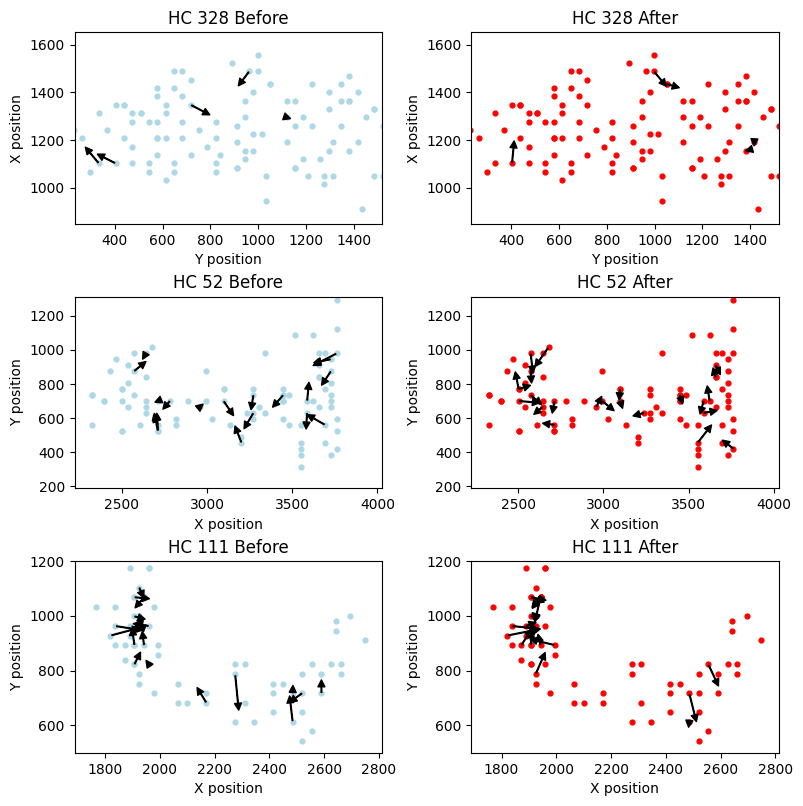

In [282]:
combined_arrow_plots(data_info)

In [2]:
data_info2 = [
    (hc_112823_data[0], 'HC 112823 Before', False, (300, 1300), (800, 1300)),
    (hc_112823_data[1], 'HC 112823 After', False, (300, 1300), (800, 1300)),
    (hc_112823_2_data[0], 'HC 112823 2 Before', False, (300, 1600), (800, 1500)),
    (hc_112823_2_data[1], 'HC 112823 2 After', False, (300, 1600), (800, 1500)),
    (hc_120523_data[0], 'HC 120523 Before', False, (2600, 3100), (400, 900)),
    (hc_120523_data[1], 'HC 120523 After', False, (2600, 3100), (400, 900))
]

NameError: name 'hc_112823_data' is not defined

In [3]:
combined_arrow_plots(data_info2)

NameError: name 'combined_arrow_plots' is not defined

In [162]:

def plot_all_data(datasets, titles):
    """
    Plots all datasets in a figure with 12 subplots (2 columns, 6 rows), rotating the plots in the third row by swapping x and y positions.
    Each plot has a fixed aspect ratio of width 3 to height 2.

    Parameters:
    - datasets: A list of dictionaries, where each dictionary represents a dataset.
    - titles: A list of titles for each subplot.
    """
    nrows = len(datasets) // 2
    fig_width = 6  # Width of each subplot
    fig_height = 4  # Height of each subplot, maintaining a 3:2 ratio when considering two columns
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(8, 16))

    for idx, (data, title) in enumerate(zip(datasets, titles)):
        ax = axs[idx // 2, idx % 2]

        for key, value in data.items():
            position = np.array(value['position'])
            angle = value['angle']
            distance = value['distance']
            color = 'lightblue' if idx % 2 == 0 else 'red'

            # For the third row, swap the x and y positions and adjust the angle accordingly
            if idx // 2 == 2:  # Zero-based index for rows, so the third row is index 2
                position = position[::-1]  # Swap x and y
                angle += np.pi / 2  # Rotate the angle by 90 degrees
                
            # Recalculate the endpoint after adjusting the angle for the third row
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])

            # reduce size of plots
            ax.plot(position[0], position[1], 'o', color=color, markersize=4)

            if not np.isnan(angle):
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_title(title)
    
    # Adjust the legend
    fig.legend([Patch(color='lightblue', label='Before'), 
                Patch(color='red', label='After'), 
                FancyArrow(0, 0, 0.1, 0.1, color='black')],
               ['Before', 'After', 'Direction'], 
               loc='upper right')

    plt.tight_layout(pad=0)
    plt.show()

In [156]:
datasets = [hc_111_data[0], hc_111_data[1], hc_52_data[0], hc_52_data[1], hc_328_data[0], hc_328_data[1], hc_112823_data[0], hc_112823_data[1], hc_112823_2_data[0], hc_112823_2_data[1], hc_120523_data[0], hc_120523_data[1]]
titles = ['Hc111 Before', 'Hc111 After', 'Hc52 Before', 'Hc52 After', 'Hc328 Before', 'Hc328 After', 'Hc112823 Before', 'Hc112823 After', 'Hc112823_2 Before', 'Hc112823_2 After', 'Hc120523 Before', 'Hc120523 After']

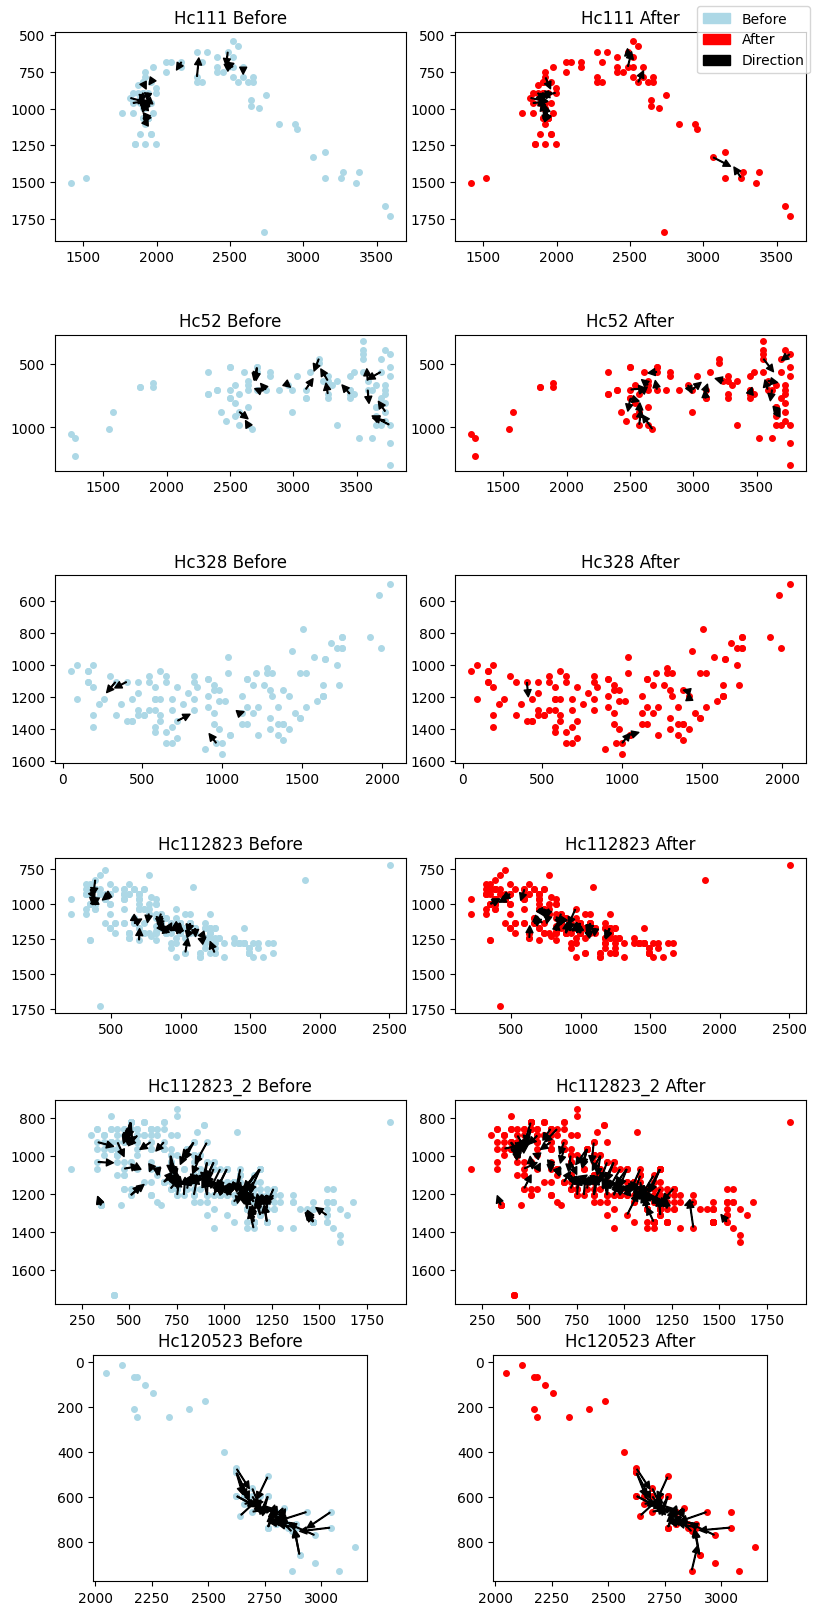

In [163]:
plot_all_data(datasets, titles)

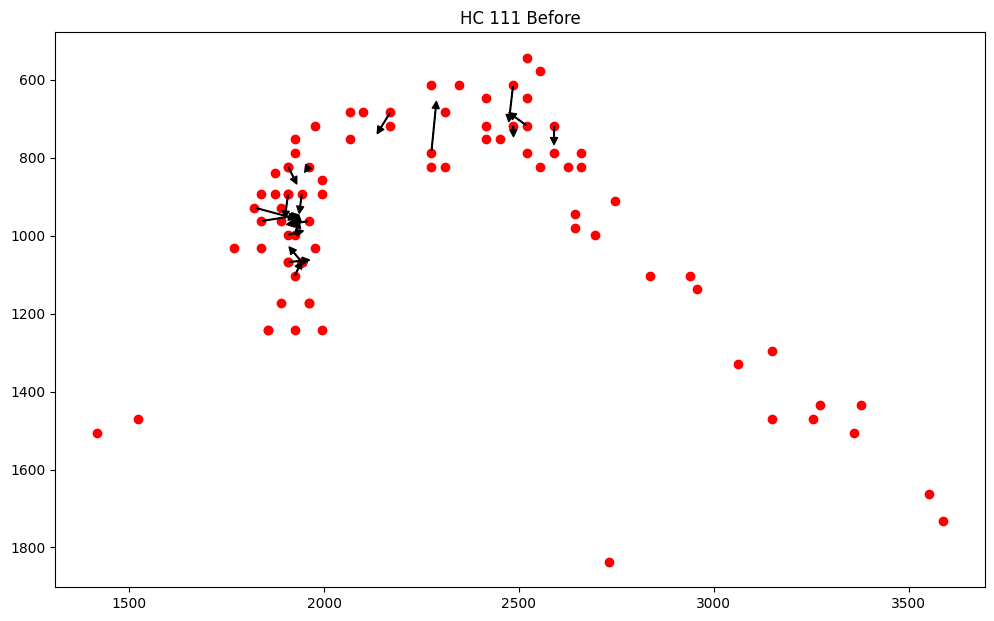

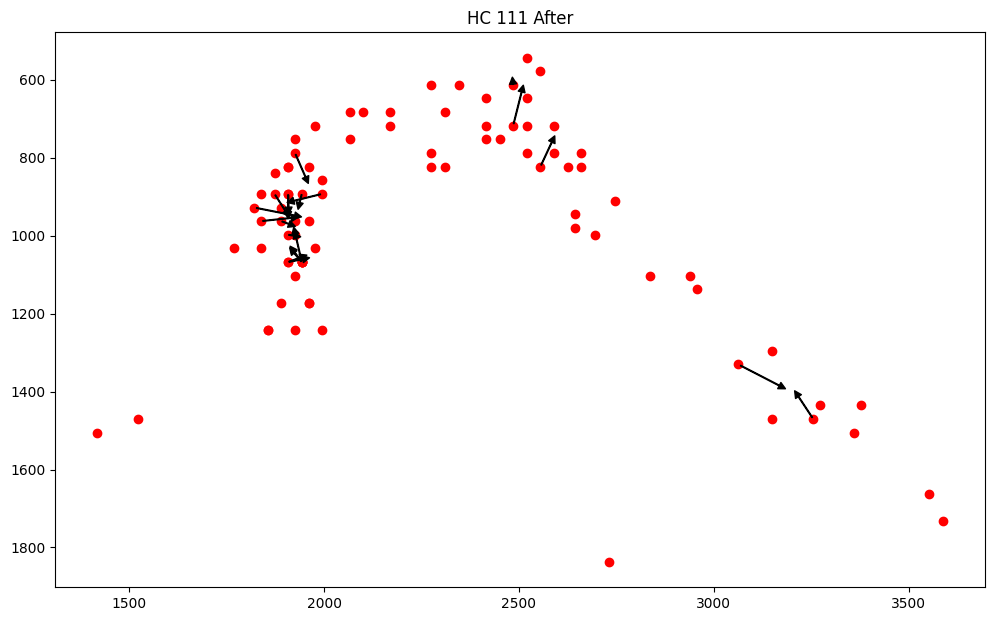

In [106]:
plot_data(hc_111_data[0], "HC 111 Before")
plot_data(hc_111_data[1], "HC 111 After")

In [113]:
def plot_combined_polar_histograms(hc_52_data):
    """
    Plots polar histograms of angles for hc_52_data[0] and hc_52_data[1] on the same plot.
    - hc_52_data[0] will be plotted in blue.
    - hc_52_data[1] will be plotted in red.
    
    Parameters:
    - hc_52_data: A list containing two datasets.
    """
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(111, polar=True)
    
    colors = ['blue', 'red']
    labels = ['Average Incoming Activity', 'Average Outgoing Activity']
    
    for i, color in enumerate(colors):
        # Extract angles from the data
        angles = [info['angle'] for info in hc_52_data[i].values() if not np.isnan(info['angle'])]
        
        # Create the histogram
        n_bins = 30  # Adjust the number of bins for the histogram if needed
        ax.hist(angles, bins=n_bins, density=True, alpha=0.6, color=color, label=labels[i])
        
    ax.set_theta_zero_location('N')  # Zero at the top
    ax.set_theta_direction(-1)  # Clockwise
    
    # Set the title and add legend
    ax.set_title('Angle Distribution')
    # set legend location
    ax.legend(loc='lower center')
    
    plt.show()

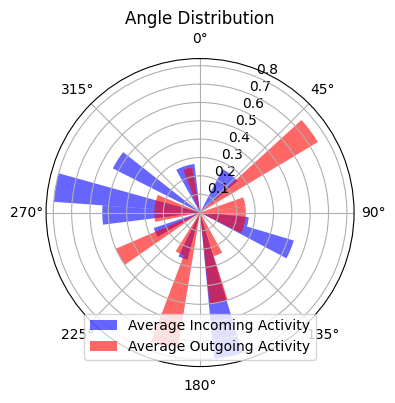

In [117]:
plot_combined_polar_histograms(hc_111_data)

In [118]:
# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 400), rank_window=5, bins=6) - vis below

# hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 300), rank_window=10, bins=6)

hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 200), rank_window=20, bins=6)

Total unique events: 21747
Processing event 0 of 21747
Processing event 2174 of 21747


/tmp/ipykernel_919/2876065909.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 4348 of 21747
Processing event 6522 of 21747
Processing event 8696 of 21747
Processing event 10870 of 21747
Processing event 13044 of 21747
Processing event 15218 of 21747
Processing event 17392 of 21747
Processing event 19566 of 21747
Processing event 21740 of 21747
Processing complete
Processing event 0 of 21747
Processing event 2174 of 21747
Processing event 4348 of 21747
Processing event 6522 of 21747
Processing event 8696 of 21747
Processing event 10870 of 21747
Processing event 13044 of 21747
Processing event 15218 of 21747
Processing event 17392 of 21747
Processing event 19566 of 21747
Processing event 21740 of 21747
Processing complete
Total unique events: 21747
Total unique events: 21747


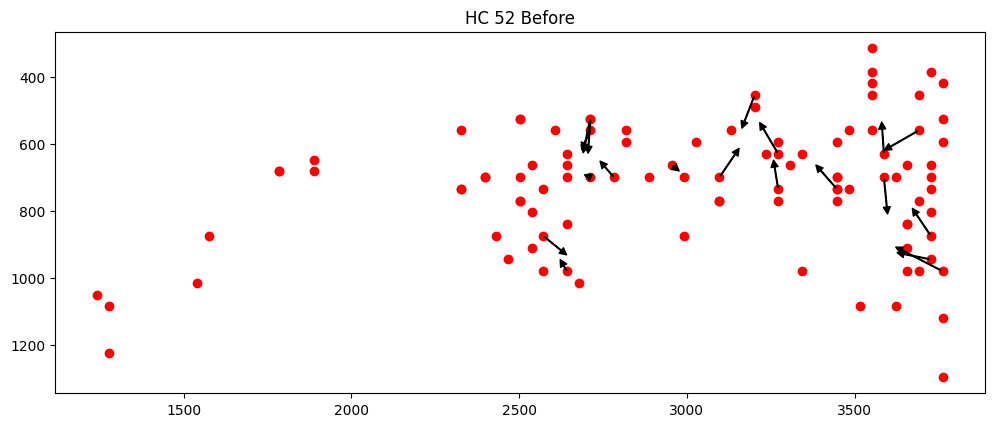

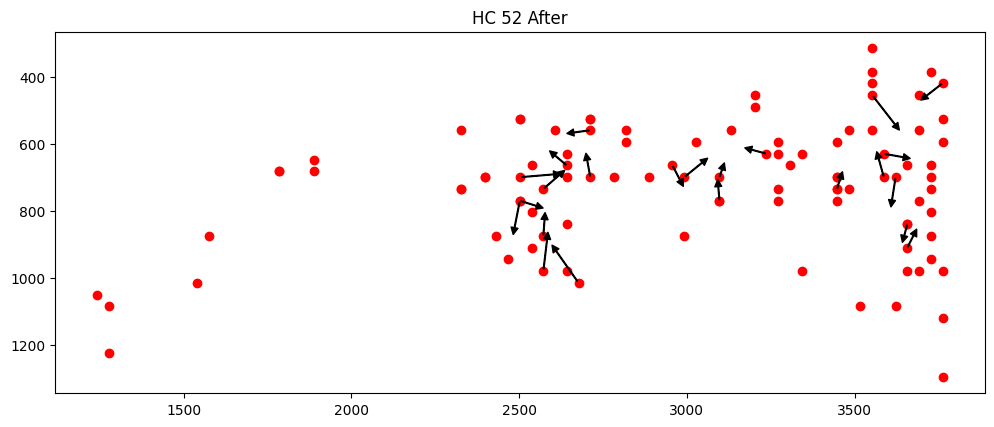

In [119]:
plot_data(hc_52_data[0], "HC 52 Before")
plot_data(hc_52_data[1], "HC 52 After")

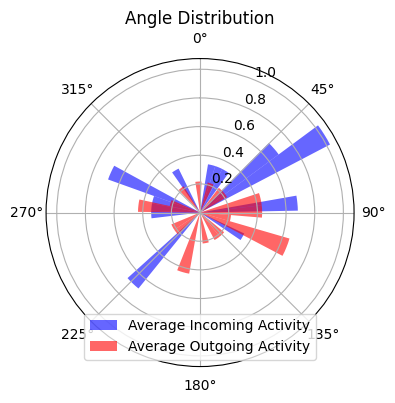

In [121]:
plot_combined_polar_histograms([hc_52_data[0], hc_52_data[1]])

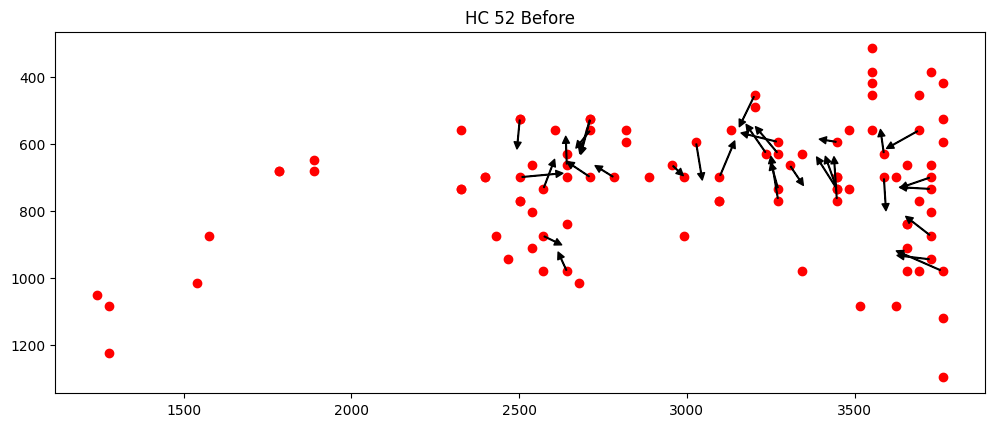

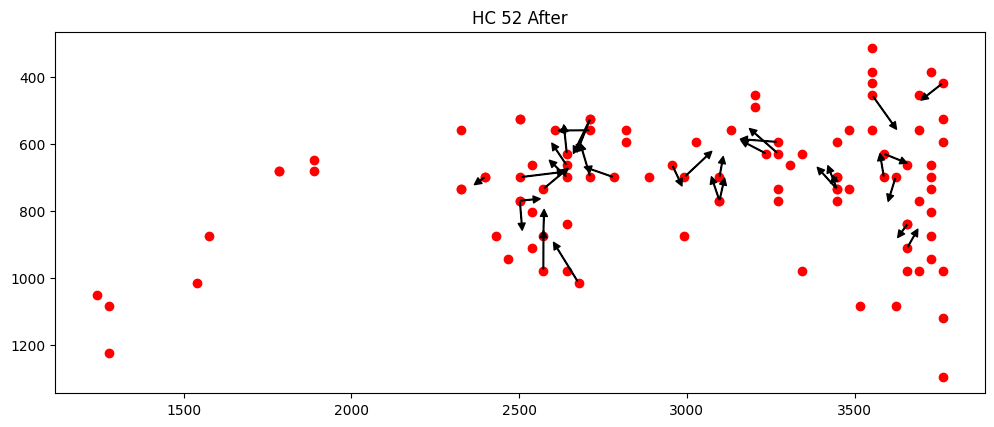

In [17]:
plot_data(hc_52_data[0], "HC 52 Before")
plot_data(hc_52_data[1], "HC 52 After")

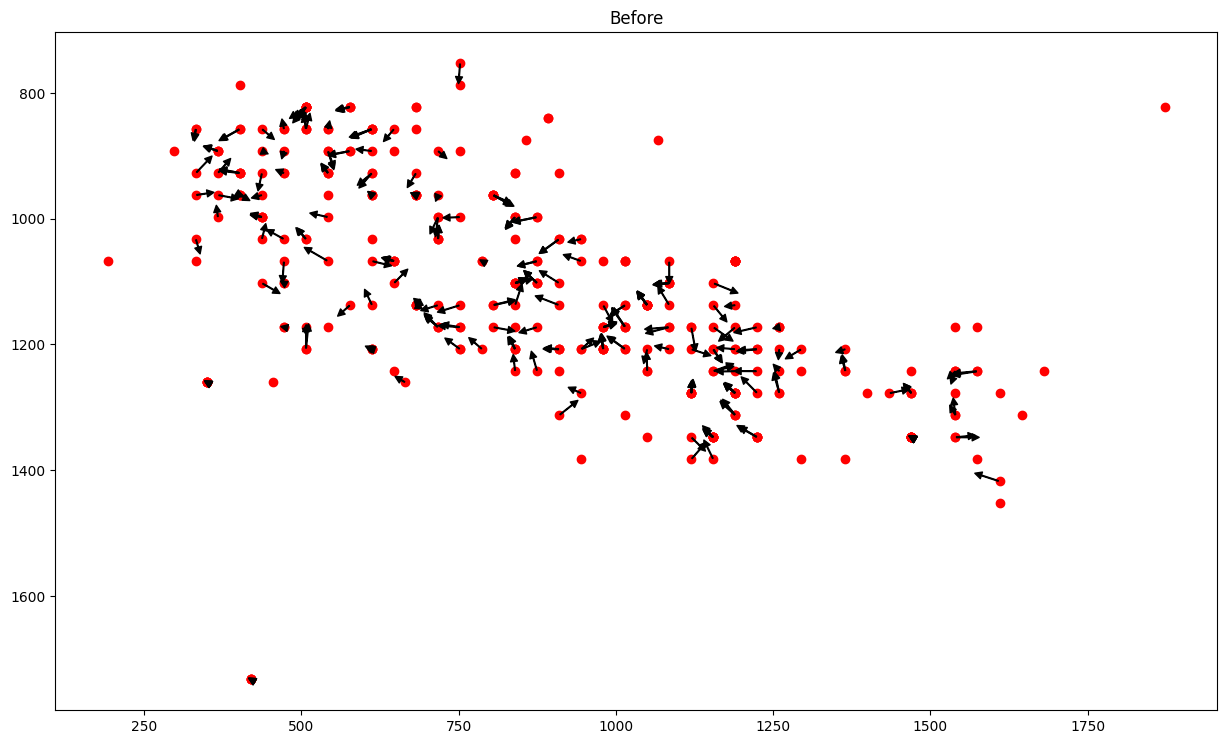

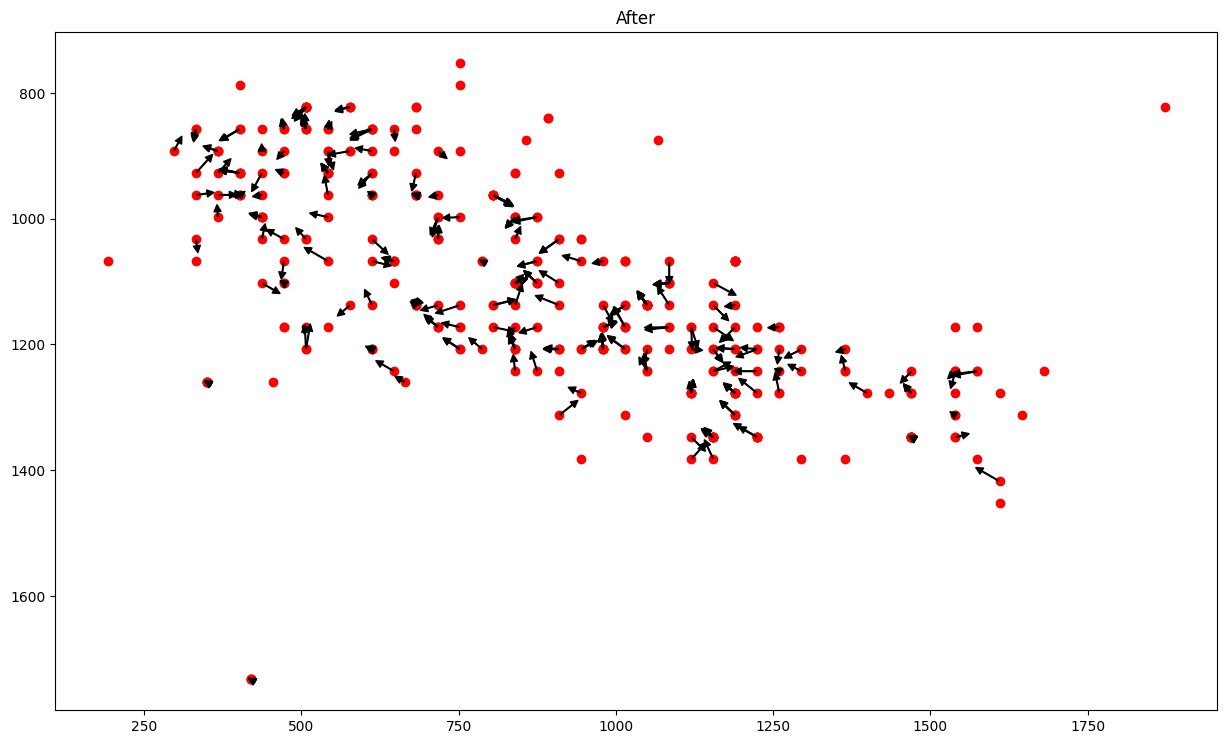

In [40]:
plot_data(before_average_events_per_neuron, "Before")
plot_data(after_average_events_per_neuron, "After")

In [28]:
sub_sd_1 = sd_1_cleaned.subtime(0, 60000)

In [31]:
event_ranks = calculate_event_ranks(sub_sd_1)
before_histograms = create_distance_angle_histograms_before(sub_sd_1, event_ranks, spatial_range=(0, 50), rank_window=500, bins=6)
after_histograms = create_distance_angle_histograms_after(sub_sd_1, event_ranks, spatial_range=(0, 50), rank_window=500, bins=6)
before_average_distances_angles = compute_average_distance_angle(before_histograms, spatial_range=(0, 50), bins=6)
after_average_distances_angles = compute_average_distance_angle(after_histograms, spatial_range=(0, 50), bins=6)

before_average_events_per_neuron = average_events_per_neuron(sub_sd_1, before_average_distances_angles)
after_average_events_per_neuron = average_events_per_neuron(sub_sd_1, after_average_distances_angles)

Total unique events: 68432
Processing event 0 of 68432


/tmp/ipykernel_18523/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 6843 of 68432
Processing event 13686 of 68432
Processing event 20529 of 68432
Processing event 27372 of 68432
Processing event 34215 of 68432
Processing event 41058 of 68432
Processing event 47901 of 68432
Processing event 54744 of 68432
Processing event 61587 of 68432
Processing event 68430 of 68432
Processing complete
Processing event 0 of 68432
Processing event 6843 of 68432
Processing event 13686 of 68432
Processing event 20529 of 68432
Processing event 27372 of 68432
Processing event 34215 of 68432
Processing event 41058 of 68432
Processing event 47901 of 68432
Processing event 54744 of 68432
Processing event 61587 of 68432
Processing event 68430 of 68432
Processing complete
Total unique events: 68432
Total unique events: 68432


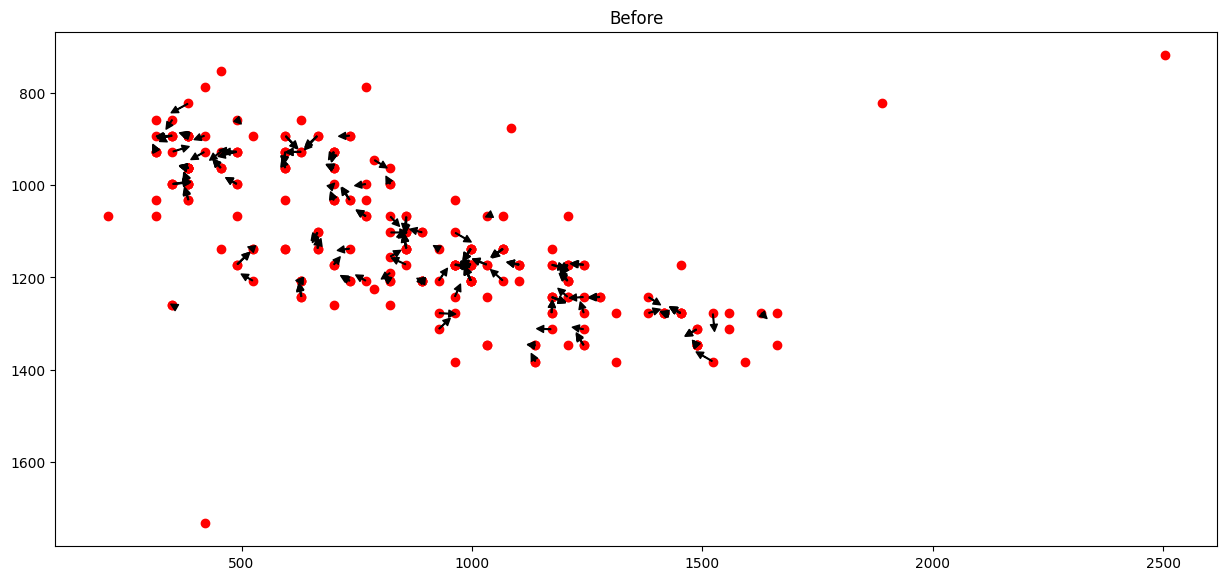

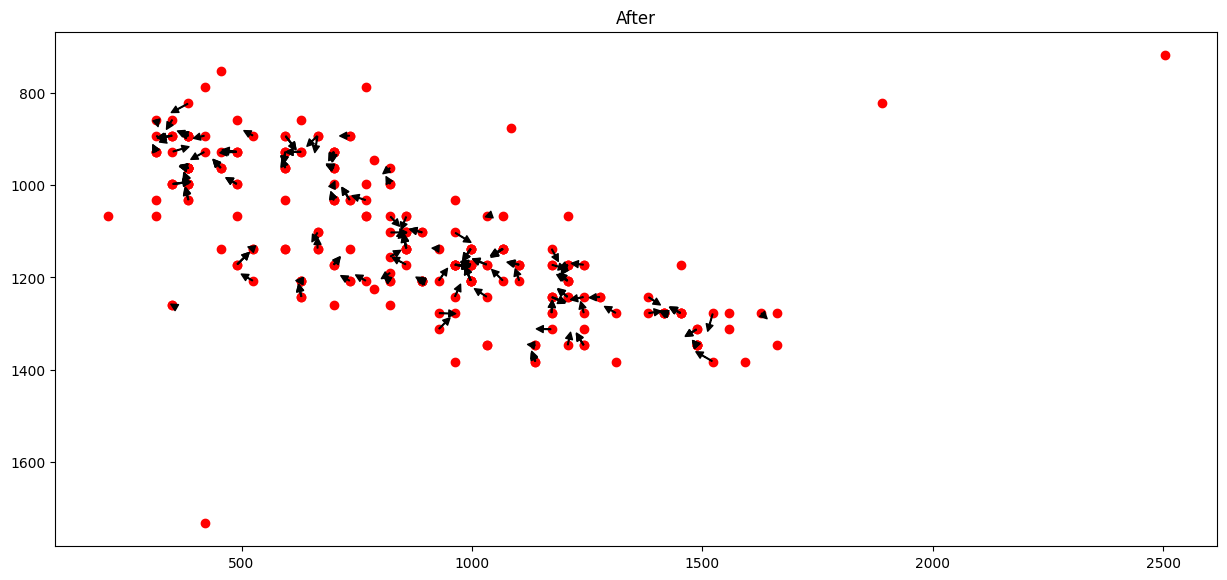

In [32]:
plot_data(before_average_events_per_neuron, 'Before')
plot_data(after_average_events_per_neuron, 'After')

# Random Data

In [18]:
event_ranks = calculate_event_ranks(sd_1_cleaned)
before_histograms = create_distance_angle_histograms_before(sd_1_cleaned, event_ranks, spatial_range=(0, 250), rank_window=1000, bins=6)
after_histograms = create_distance_angle_histograms_after(sd_1_cleaned, event_ranks, spatial_range=(0, 250), rank_window=1000, bins=6)
before_average_distances_angles = compute_average_distance_angle(before_histograms, spatial_range=(0, 250), bins=6)
after_average_distances_angles = compute_average_distance_angle(after_histograms, spatial_range=(0, 250), bins=6)

before_average_events_per_neuron = average_events_per_neuron(sd_1_cleaned, before_average_distances_angles)
after_average_events_per_neuron = average_events_per_neuron(sd_1_cleaned, after_average_distances_angles)

Total unique events: 338136
Processing event 0 of 338136


/tmp/ipykernel_18523/1974472676.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 33813 of 338136
Processing event 67626 of 338136
Processing event 101439 of 338136
Processing event 135252 of 338136
Processing event 169065 of 338136
Processing event 202878 of 338136
Processing event 236691 of 338136
Processing event 270504 of 338136
Processing event 304317 of 338136
Processing event 338130 of 338136
Processing complete
Processing event 0 of 338136
Processing event 33813 of 338136
Processing event 67626 of 338136
Processing event 101439 of 338136
Processing event 135252 of 338136
Processing event 169065 of 338136
Processing event 202878 of 338136
Processing event 236691 of 338136
Processing event 270504 of 338136
Processing event 304317 of 338136
Processing event 338130 of 338136
Processing complete
Total unique events: 338136
Total unique events: 338136


In [19]:
# pickle sd_data for before after events
with open('before_average_events_per_neuron.pkl', 'wb') as f:
    pickle.dump(before_average_events_per_neuron, f)

with open('after_average_events_per_neuron.pkl', 'wb') as f:
    pickle.dump(after_average_events_per_neuron, f)

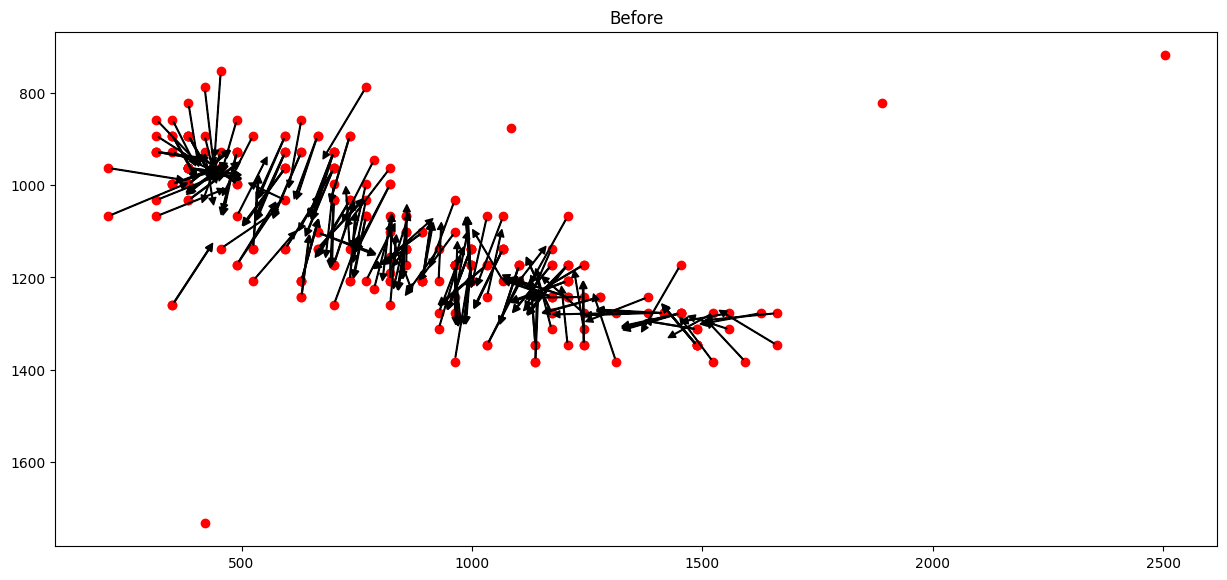

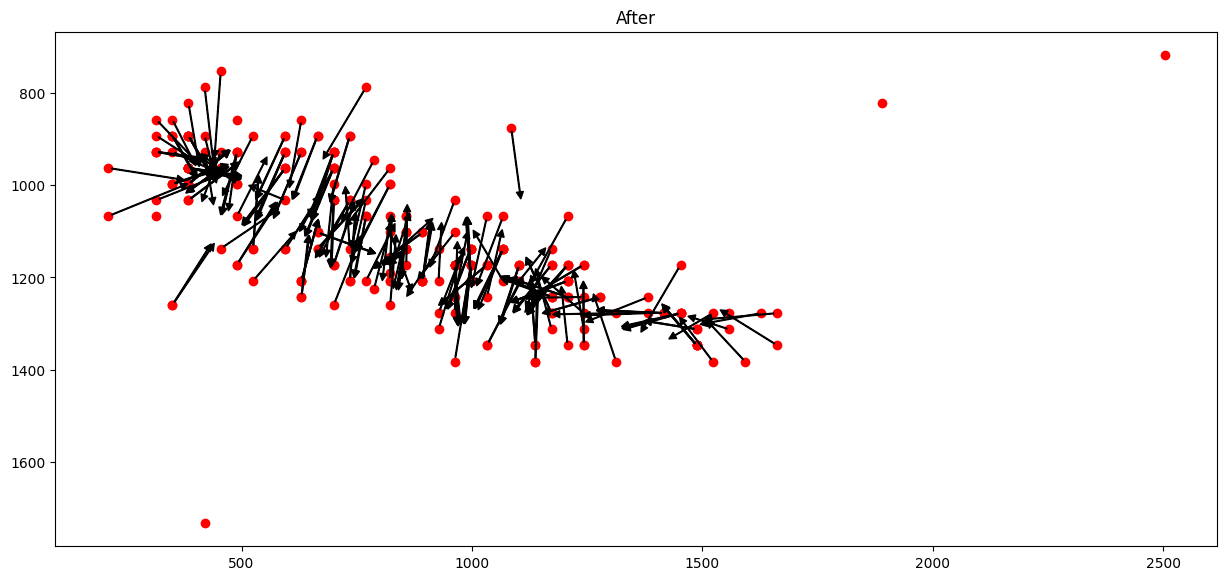

In [20]:
plot_data(before_average_events_per_neuron, 'Before')
plot_data(after_average_events_per_neuron, 'After')

# Linear Wave Data

In [ ]:
linear_event_ranks = calculate_event_ranks(sd_linear)
linear_before_histograms = create_distance_angle_histograms_before(sd_linear, linear_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
linear_after_histograms = create_distance_angle_histograms_after(sd_linear, linear_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
linear_before_average_distances_angles = compute_average_distance_angle(linear_before_histograms, spatial_range=(0, 2), bins=6)
linear_after_average_distances_angles = compute_average_distance_angle(linear_after_histograms, spatial_range=(0, 2), bins=6)

linear_before_average_events_per_neuron = average_events_per_neuron(sd_linear, linear_before_average_distances_angles)
linear_after_average_events_per_neuron = average_events_per_neuron(sd_linear, linear_after_average_distances_angles)

Total unique events: 66560
Processing event 0 of 66560


/tmp/ipykernel_34901/3952896221.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 6656 of 66560
Processing event 13312 of 66560
Processing event 19968 of 66560
Processing event 26624 of 66560
Processing event 33280 of 66560
Processing event 39936 of 66560
Processing event 46592 of 66560
Processing event 53248 of 66560
Processing event 59904 of 66560
Processing complete
Processing event 0 of 66560
Processing event 6656 of 66560
Processing event 13312 of 66560
Processing event 19968 of 66560
Processing event 26624 of 66560
Processing event 33280 of 66560
Processing event 39936 of 66560
Processing event 46592 of 66560
Processing event 53248 of 66560
Processing event 59904 of 66560
Processing complete
Total unique events: 66560
Total unique events: 66560


# Circular Wave Data

In [ ]:
circle_event_ranks = calculate_event_ranks(sd_circle)
circle_before_histograms = create_distance_angle_histograms_before(sd_circle, circle_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
circle_after_histograms = create_distance_angle_histograms_after(sd_circle, circle_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
circle_before_average_distances_angles = compute_average_distance_angle(circle_before_histograms, spatial_range=(0, 2), bins=6)
circle_after_average_distances_angles = compute_average_distance_angle(circle_after_histograms, spatial_range=(0, 2), bins=6)

circle_before_average_events_per_neuron = average_events_per_neuron(sd_circle, circle_before_average_distances_angles)
circle_after_average_events_per_neuron = average_events_per_neuron(sd_circle, circle_after_average_distances_angles)

Total unique events: 49408
Processing event 0 of 49408


/tmp/ipykernel_34901/3952896221.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 4940 of 49408
Processing event 9880 of 49408
Processing event 14820 of 49408
Processing event 19760 of 49408
Processing event 24700 of 49408
Processing event 29640 of 49408
Processing event 34580 of 49408
Processing event 39520 of 49408
Processing event 44460 of 49408
Processing event 49400 of 49408
Processing complete
Processing event 0 of 49408
Processing event 4940 of 49408
Processing event 9880 of 49408
Processing event 14820 of 49408
Processing event 19760 of 49408
Processing event 24700 of 49408
Processing event 29640 of 49408
Processing event 34580 of 49408
Processing event 39520 of 49408
Processing event 44460 of 49408
Processing event 49400 of 49408
Processing complete
Total unique events: 49408
Total unique events: 49408


# Loop Wave Data

In [13]:
loop_event_ranks = calculate_event_ranks(sd_loop)
loop_before_histograms = create_distance_angle_histograms_before(sd_loop, loop_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
loop_after_histograms = create_distance_angle_histograms_after(sd_loop, loop_event_ranks, spatial_range=(0, 2), rank_window=1000, bins=6)
loop_before_average_distances_angles = compute_average_distance_angle(loop_before_histograms, spatial_range=(0, 2), bins=6)
loop_after_average_distances_angles = compute_average_distance_angle(loop_after_histograms, spatial_range=(0, 2), bins=6)

loop_before_average_events_per_neuron = average_events_per_neuron(sd_loop, loop_before_average_distances_angles)
loop_after_average_events_per_neuron = average_events_per_neuron(sd_loop, loop_after_average_distances_angles)

Total unique events: 12672
Processing event 0 of 12672


/tmp/ipykernel_34901/3952896221.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 1267 of 12672
Processing event 2534 of 12672
Processing event 3801 of 12672
Processing event 5068 of 12672
Processing event 6335 of 12672
Processing event 7602 of 12672
Processing event 8869 of 12672
Processing event 10136 of 12672
Processing event 11403 of 12672
Processing event 12670 of 12672
Processing complete
Processing event 0 of 12672
Processing event 1267 of 12672
Processing event 2534 of 12672
Processing event 3801 of 12672
Processing event 5068 of 12672
Processing event 6335 of 12672
Processing event 7602 of 12672
Processing event 8869 of 12672
Processing event 10136 of 12672
Processing event 11403 of 12672
Processing event 12670 of 12672
Processing complete
Total unique events: 12672
Total unique events: 12672


# BIG PLOT

In [28]:
def plot_all_data(datasets, titles):
    """
    Plots all datasets in a figure with 8 subplots (2 columns, 4 rows).

    Parameters:
    - datasets: A list of dictionaries, where each dictionary represents a dataset with the same format as before.
    - titles: A list of titles for each subplot.
    """
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 16)) # Adjust the figsize if needed

    for idx, (data, title) in enumerate(zip(datasets, titles)):
        ax = axs[idx // 2, idx % 2] # Calculate the correct row and column index
        for key, value in data.items():
            position = np.array(value['position'])  # Ensure position is a numpy array
            angle = value['angle']
            distance = value['distance'] # Adjusting distance if needed for visualization

            # If idx is even, plot the point in pale blue; otherwise, plot the point in red
            if idx % 2 == 0:
                # Plotting the point in pale blue
                ax.plot(position[0], position[1], 'o', color='lightblue')
            else:
                # Plotting the point in red
                ax.plot(position[0], position[1], 'o', color='red')

            # Skip plotting the arrow if angle is nan
            if not np.isnan(angle):
                # Calculate the end point of the arrow
                end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
                
                # Plotting the arrow
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
                
        ax.set_aspect('equal')
        # Invert y axis
        ax.invert_yaxis()
        ax.set_title(title)
    
    # Add legend for blue and red points
    blue_patch = Patch(color='lightblue', label='Receiver')
    red_patch = Patch(color='red', label='Sender')

    # Add legend for arrows
    arrow = FancyArrow(0, 0, 1, 1, color='black', width=0.5, head_width=5, head_length=5)
    ax.legend([blue_patch, red_patch, arrow], ['Receiver', 'Sender', 'Direction'], loc='upper right')

    plt.tight_layout()
    plt.show()

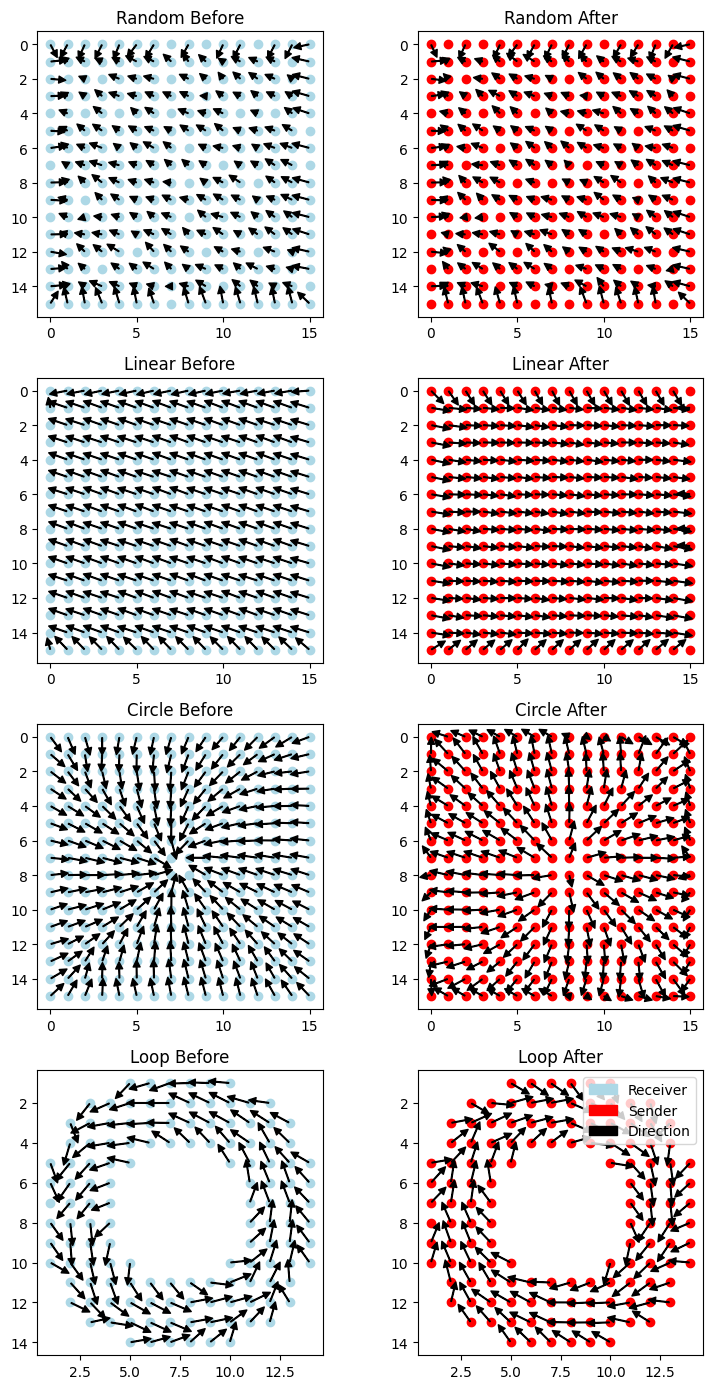

In [29]:
datasets = [
    random_before_average_events_per_neuron,
    random_after_average_events_per_neuron,
    linear_before_average_events_per_neuron,
    linear_after_average_events_per_neuron,
    circle_before_average_events_per_neuron,
    circle_after_average_events_per_neuron,
    loop_before_average_events_per_neuron,
    loop_after_average_events_per_neuron
]

titles = [
    "Random Before",
    "Random After",
    "Linear Before",
    "Linear After",
    "Circle Before",
    "Circle After",
    "Loop Before",
    "Loop After"
]

plot_all_data(datasets, titles)

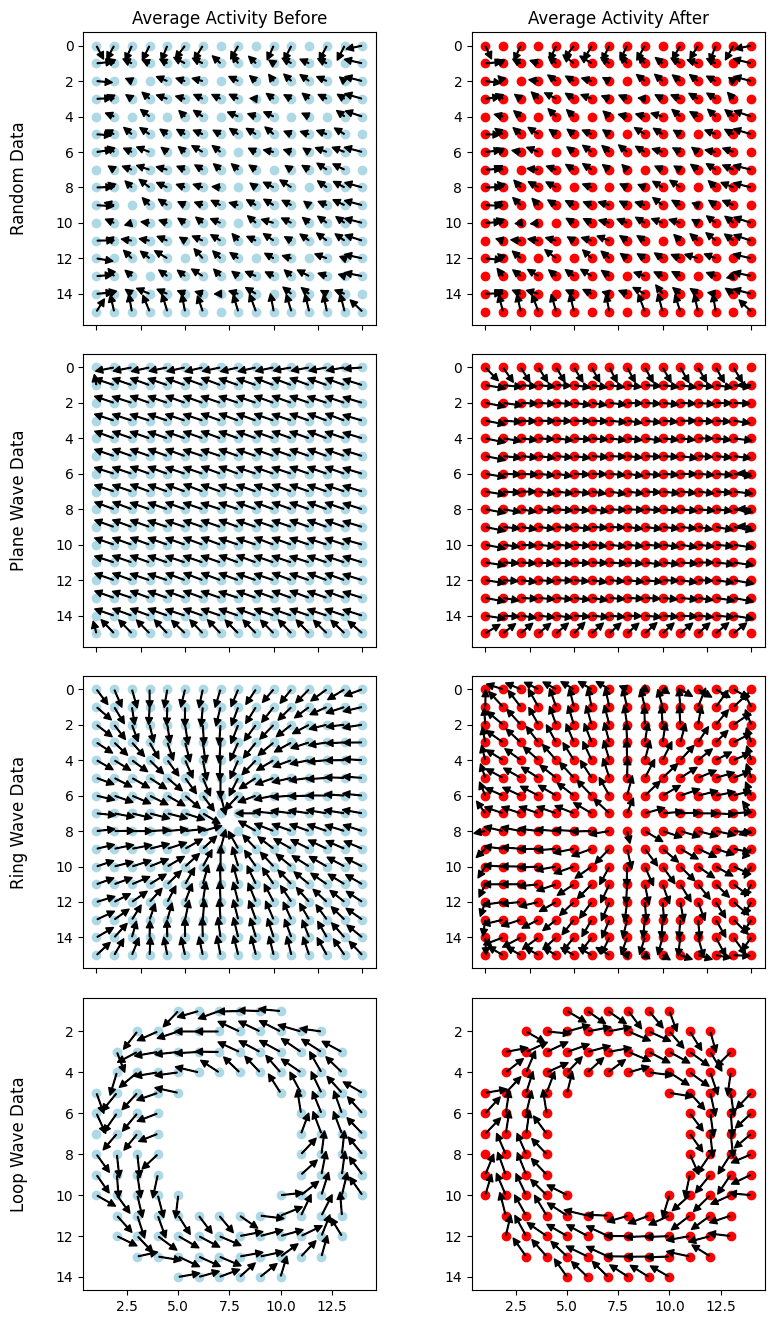

In [37]:
def plot_all_data_revised(datasets):
    """
    Plots all datasets in a figure with 8 subplots arranged in 2 columns and 4 rows, with adjusted height.
    - datasets: A list of dictionaries, where each dictionary represents a dataset.
    """
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 14.5))  # Adjusted figure size
    
    row_titles = ["Random Data", "Plane Wave Data", "Ring Wave Data", "Loop Wave Data"]  # Assuming 'Plane' is a typo for 'Linear'
    column_titles = ["Average Activity Before", "Average Activity After"]
    
    # Plot each dataset
    for idx, (data, title) in enumerate(zip(datasets, titles)):
        ax = axs[idx // 2, idx % 2] # Calculate the correct row and column index
        for key, value in data.items():
            position = np.array(value['position'])  # Ensure position is a numpy array
            angle = value['angle']
            distance = value['distance'] # Adjusting distance if needed for visualization

            # If idx is even, plot the point in pale blue; otherwise, plot the point in red
            if idx % 2 == 0:
                # Plotting the point in pale blue
                ax.plot(position[0], position[1], 'o', color='lightblue')
            else:
                # Plotting the point in red
                ax.plot(position[0], position[1], 'o', color='red')

            # Skip plotting the arrow if angle is nan
            if not np.isnan(angle):
                # Calculate the end point of the arrow
                end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
                
                # Plotting the arrow
                ax.annotate('', xy=end_point, xytext=position,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))
                
            # Add row titles on the right or left
            if idx % 2 == 0:  # For the first column
                ax.set_ylabel(row_titles[idx // 2], rotation=90, size='large', labelpad=20)
                
        ax.set_aspect('equal')
        # Invert y axis
        ax.invert_yaxis()

        # Remove x-axis labels for all but the bottom row
        if idx // 2 != 3:
            ax.set_xticklabels([])

    # Add column titles
    for ax, col_title in zip(axs[0], column_titles):
        ax.set_title(col_title)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameters as needed

    # Reduce space between each column and row
    plt.subplots_adjust(wspace=-0.1, hspace=0.1)
    
    # Show plot
    plt.show()

# Assuming the datasets variable is predefined as in your previous message
plot_all_data_revised(datasets)